In [1]:
from vc_clothes_data_module import VCClothesDataModule

from face_feature_extractor import FaceFeatureExtractor
from appearance_branch import AppearanceBranch
from fusion_module import FusionModule


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

c:\25Z\GSN\projekt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = "./data/vc_clothes"
BATCH_SIZE = 128

EMBEDING_DIM = 512

In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision("medium")

PyTorch version: 2.9.1+cu130
CUDA available: True
Device name: NVIDIA GeForce RTX 5060 Ti


In [ ]:
dm = VCClothesDataModule(root_dir=DATA_ROOT, batch_size=BATCH_SIZE, num_workers=5)


face_branch = FaceFeatureExtractor(embedding_dim=EMBEDING_DIM)

app_branch = AppearanceBranch(embedding_dim=EMBEDING_DIM)


try:
    # checkpoint_path = ".\lightning_logs\version_65\checkpoints\face-reid-epoch=49-val_acc=0.95.ckpt"
    checkpoint_path = "nowy model"
    model = FusionModule.load_from_checkpoint(
        checkpoint_path,
        appearance_net=app_branch,
        face_net=face_branch,
        fusion_weight=0.9,
    )
except:
    model = FusionModule(
        appearance_net=app_branch, face_net=face_branch, fusion_weight=0.9
    )

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc", mode="max", filename="face-reid-{epoch:02d}-{val_acc:.2f}"
)

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",  # Automatycznie wykryje GPU
    devices=1,
    callbacks=[checkpoint_callback],
    # log_every_n_steps=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | Fusion           | 31.2 M | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
7.7 M     Trainable params
23.5 M    Non-trainable params
31.2 M    Total params
124.783   Total estimated model params size (MB)
385       Modules in train mode
0         Modules in eval mode
0         Total Flops


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Epoch 49: 100%|██████████| 67/67 [00:13<00:00,  5.11it/s, v_num=65, train_loss_step=0.590, val_loss=0.844, val_acc=0.954, train_loss_epoch=0.573, train_acc=0.998] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 67/67 [00:14<00:00,  4.78it/s, v_num=65, train_loss_step=0.590, val_loss=0.844, val_acc=0.954, train_loss_epoch=0.573, train_acc=0.998]


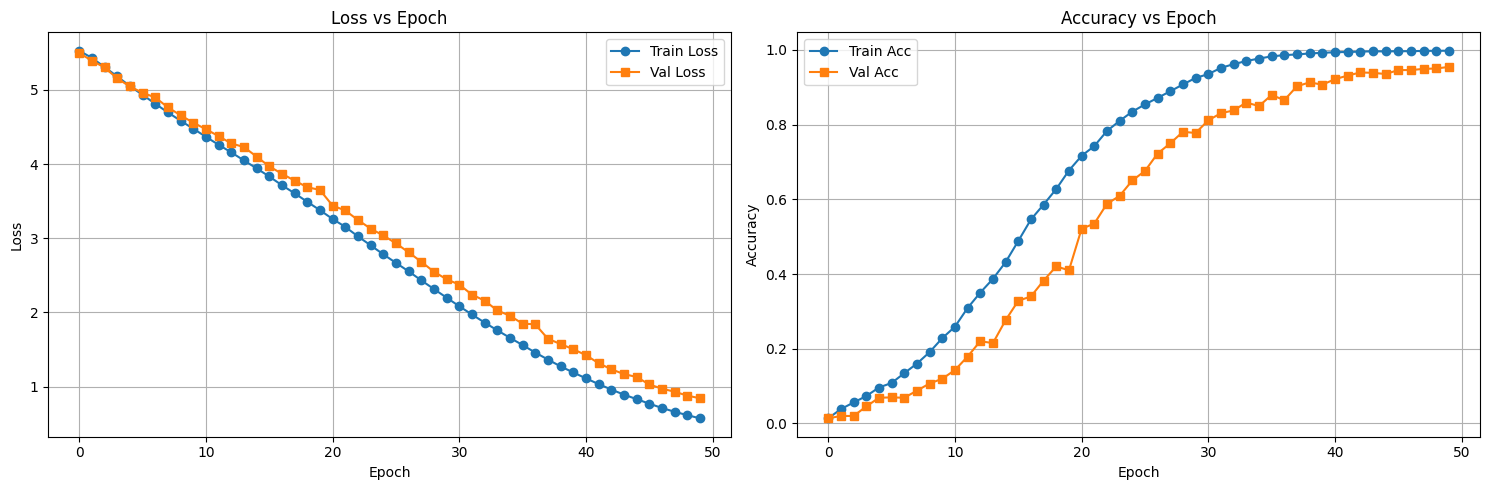

In [2]:
from plot_metrics import plot_metrics

plot_metrics("./lightning_logs/version_65/metrics.csv")


In [6]:
trainer.test(model, datamodule=dm)

Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 1: 100%|██████████| 68/68 [00:06<00:00, 10.09it/s]
--- Wyniki Testowe ---
mAP: 24.43%
Rank-1: 46.61%
Rank-5: 58.98%
Rank-10: 64.28%
---------------------
Testing DataLoader 1: 100%|██████████| 68/68 [00:07<00:00,  9.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.46614328026771545      0.46614328026771545
       test_Rank10          0.6427870392799377       0.6427870392799377
       test_Rank5           0.5897939205169678       0.5897939205169678
        test_mAP            0.24428905546665192      0.24428905546665192
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mAP': 0.24428905546665192,
  'test_Rank1': 0.46614328026771545,
  'test_Rank5': 0.5897939205169678,
  'test_Rank10': 0.6427870392799377},
 {'test_mAP': 0.24428905546665192,
  'test_Rank1': 0.46614328026771545,
  'test_Rank5': 0.5897939205169678,
  'test_Rank10': 0.6427870392799377}]